<center>

# Anomaly Detection with Quantum Annealers

</center>

<br>

----

<br>


## Description

Anomaly detection is the identification of abnormal behavior in data, which manifests in individual data
points that differ significantly from the majority of
the data. This task frequently appears in many domains including finance,
medicine and telecommunications. A particularly challenging application of Anomaly Detection
can be found in Endpoint Detection and Response
(EDR), which aims at detecting and investigating suspicious activities on endpoints such as mobile phones
or workstations in cybersecurity. In
practice, the respective networks can be comprised of
billions of nodes, generating an immense amount of
data, in which the search for extremely scarce, malicious anomalies can be very tedious.
This vast number of typically high-dimensional
data points and additional impediments such as zeroday attacks raise a demand for suitable anomaly detection techniques deviating from the still widely used manual and rule-based approaches. While many
classical machine learning approaches to this mostly
unsupervised learning problem exist, the distinction between malicious and benign
anomalies frequently remains intractable due to insufficient generalization (Karami, 2018). This problem
substantiates in a trade-off between detecting an unacceptably high number of false positives (i.e., benign
data) and failing to reliably detect all true positives
(i.e., the malicious anomalies).

In the following notebook we demonstrate the application of Quantum Computing (QC)
to this problem, as QC has shown promising performance in generative data modelling, which is a popular technique used in unsupervised anomaly detection. Specifically, we implement the Quantum Boltzmann Machine algorithm implemented on a Qauntum Annealer for unsupervised learning.




In [2]:

from pathlib import Path
from src.utils import import_dataset, split_dataset_labels, split_data
from src import drawer
from src.qbm import QBM
from src.rbm import RBM
from src.helper import get_model,evaluate_qbm,evaluate_rbm,compare_models
import numpy as np
import random
import warnings
warnings.filterwarnings("ignore")

## Problem Specification



<center>

We generate a synthetic data set, aimed at matching the following properties found in real world data: 
- a high dimensionality to assess scaling performance 
- scarce anomalies 

- a substantial number of data points. 

While (2) and (3) are straightforward, (1) is directly
proportional to the number of visible units and thus
the space complexity compromising on the dimensionality. Compromising (1) to facilitate a visual evaluation and retain enough space for exploring a large
space of hidden units for this first case study on fully
unsupervised anomaly detection using a QBM, we
restrict the data set to three dimensions. To satisfy
(2) and (3) within the limitations of current hardware
capabilities, we thus generate 1007 3D data points
x ∈ [0,...,127]

clustered in five clusters and containing seven anomalies using the method make blobs
from scikit-learn (Pedregosa et al., 2011). Therefore, seven bits are required per dimension, which
means that 21 visible neurons are needed to represent the QBM’s input, i.e., a single data point. Due
to the 50/50 train/test split, the ratio of anomalies is
≤ 7/500 ≈ 1%, satisfying (2). A pairplot of the generated data set is displayed below.

The task would be to then detect the outliers in an unsupervised manner such that the number of false positives remain fairly low.
</center>



Currently drawing l_o7_c5_d3_p200_v1.


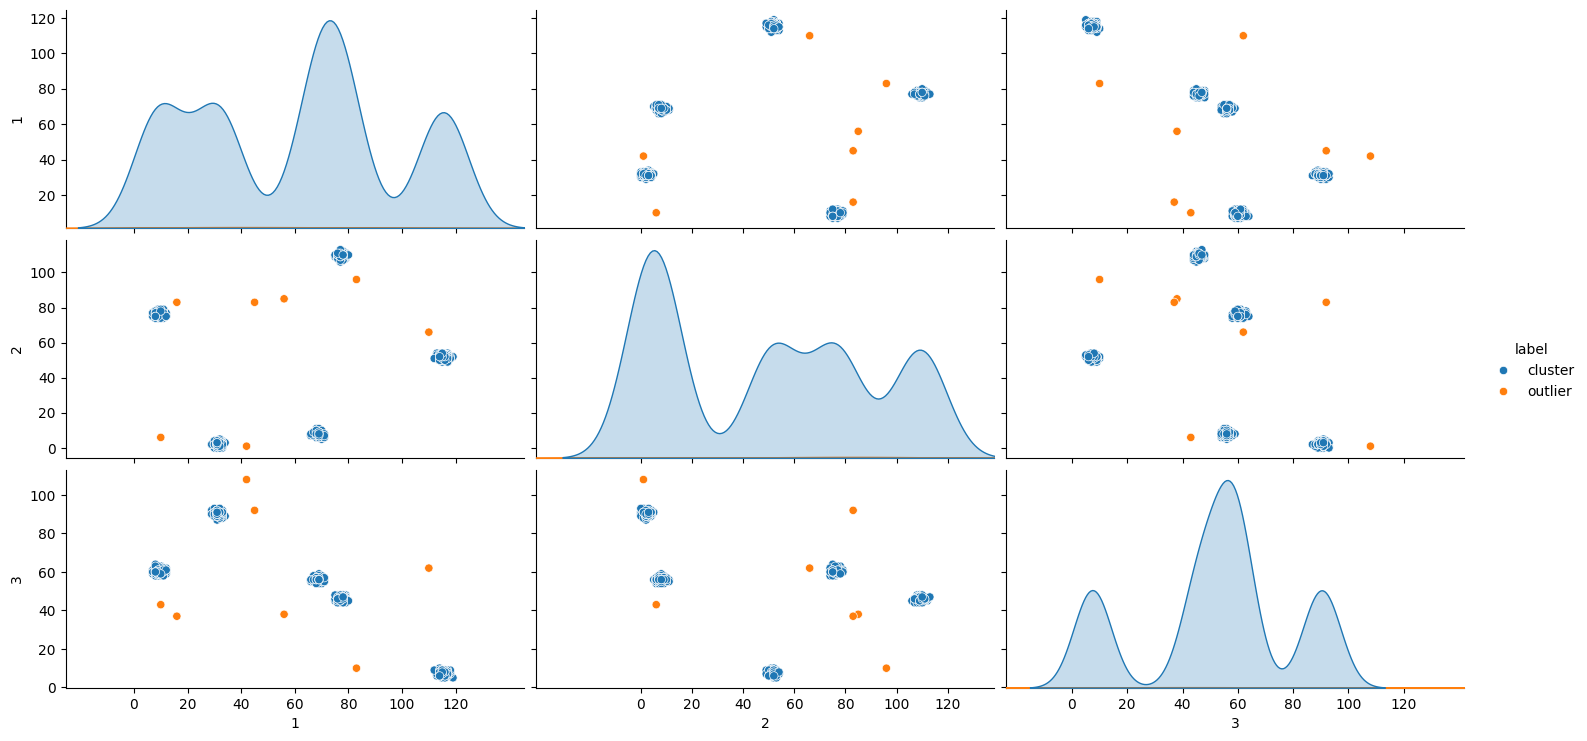

In [3]:
# Plotting the full dataset

## pre-saved 3D dataset in folder datasets
dataset_path = Path('./src/datasets/l_o7_c5_d3_p200_v1.npy')

# Specify the number of clusters in the dataset
cluster=5  

# set seed 
np.random.seed(2)
random.seed(2)



# importing dataset
data = import_dataset(dataset_path)

training_dataset, testing_dataset = split_data(data=data, clusters=5)
training_data, training_labels = split_dataset_labels(training_dataset)


# Draw dataset
drawer.draw_dataset(dataset_path)



 ## QBM's

A QBM is a machine learning model of the form of a variational Gibbs state [1].
$$ \rho_\theta = \frac{ e^{-\beta \hspace{0.05cm} H_\theta} }
                       { Tr {(e^{-\beta  \hspace{0.05cm} H_\theta})} } $$

where $H_\theta$ is a Hamiltonian parameterized by variational parameters $\theta$, acting on $n_v$ visible and $n_h$ hidden qubits.
 
$$
    H_\theta = \sum_{i=1}^{K} \theta_i h_i $$

where $\theta \in \mathbb{R}^K$ and $h_i = {\bigotimes}_{j=1}^{n} \hspace{0.1cm} \sigma_{j,i}$ with $\sigma_{j,i} \in \{ I, X, Y, Z \}$ and $n = n_v + n_h$. 
A QBM can be used for generative modeling of classical and quantum data and is trained using the POVM-based Golden-Thompson training.

A discrete target probability distribution $Q$, specified by probabilities $\{q^{v}\}$, and a POVM $\{\Lambda_{v} \otimes I_h\}$ acting non-trivially only on the visible subsystem. 
We optimize the QBM such that the probability distribution $P_\theta$ defined by the outcome probabilities $p^{v}_\theta = Tr{(\Lambda_{v} \otimes I_h) \rho_\theta}$ of a POVM measurement specified by $\{\Lambda_{v}\}$ on $\rho_\theta$, is as close as possible to $Q$.
This is achieved by minimizing the Kullback-Leibler divergence ${D_{\text{KL}} (Q \Vert P_{\theta}) = \sum_{v} q^{v} \log \left( \frac{q^{v}}{p^{v}_\theta} \right)}$ via gradient descent. 

$$
     \partial_{\theta_i} D_{\text{KL}} (Q \Vert \widetilde{P}_{\theta}) 
    = 
    \overline{\langle \partial_{\theta_i} H_\theta^{v}  \rangle}_{v} 
    - 
    \langle \partial_{\theta_i} H_\theta  \rangle_{\rho_\theta} $$

where 
$$ 
    \overline{\langle \hspace{0.1cm} \boldsymbol{\cdot} \hspace{0.1cm} \rangle}_{v}
    = 
    \sum_v q^{v} \hspace{0.05cm} \langle \hspace{0.1cm} {\cdot} \hspace{0.1cm} \rangle_{v}
    = 
    \sum_{v} q^{v} \hspace{0.05cm} Tr({
    \frac{ 
    e^{-\beta H_\theta^{v}} }
    { Tr({e^{-\beta H_\theta^{v}}} }) \hspace{0.1cm} {\cdot} \hspace{0.1cm}
    } $$
For the Hamiltonian of the form that is implemented in Quantum Annealers:


$$
    %H_{(\Upgamma,\, b,\, w)} 
    H_{\theta}
    = 
    - \sum_i \Gamma_i \sigma^x_i - \sum_i b_i \sigma^z_i - \sum_{ij} w_{ij} \sigma^z_i \sigma^z_j $$

The weights updates then take the form :
$$ \delta b_i= \overline{\langle \sigma^z_i \rangle_v} - \langle\sigma^z_i \rangle$$
$$ \delta w_{ij} = \overline{\langle \sigma^z_i \sigma^z_j\rangle_v} - \langle\sigma^z_i\sigma^z_j \rangle$$

### Annealer Architecture


In a QBM, the qubits are allowed to have interconnections between the visible units as opposed to the classical RBM. The number of visible units is equal to the number of bits required to represent a given data point. In the chosen dataset we have 3 features and each feature requires 7 bits each. Therefore the visible layer consist of 21 qubits.
<center>

<img src="images/Annealing_architecture.png" width="500">

</center>

## Training and Testing the QBM

The training for the QBM could be time-consuming compared to the model hyper-parameters, here we train a model with relatively low number of hidden units for exposition.

### Training a model with 6 hidden units



In [6]:
# Train new model with training_data (inputs only)


qbm = QBM(training_data, epochs=5, n_hidden_nodes=40, seed=77, weight_csv=None, solver="SA",
                 sample_count=20, anneal_steps=20, beta_eff=1, quantile=0.95, trained=False, restricted=True,
                 param_string="", savepoint="",save=False) 

qbm.train_model(batch_size=13, learning_rate=0.001)

Epoch 1


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:32<00:00,  1.19it/s]


Epoch 2


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:31<00:00,  1.23it/s]


Epoch 3


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:32<00:00,  1.20it/s]


Epoch 4


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:32<00:00,  1.19it/s]


Epoch 5


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:33<00:00,  1.16it/s]


Outlier threshold:  -8.81578369250051
Calculate outlier Energy


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 182.33it/s]


Calculate cluster energy


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 272.70it/s]


Outlier classification: Results...
Accuracy: 0.9443339960238568, Precision: 0.037037037037037035, Recall: 0.3333333333333333, F1-Score: 0.06666666666666667, 
Num True Negative: 474, Num False Negative: 2, Num True         Positive: 1, Num False Positive: 26
Outlier threshold:  -8.81578369250051
Average clusterpoint energy:  -12.24455115410688
Outlier energy:  [-10.60463868 -14.04778769  -8.19612477]
Currently drawing test dataset


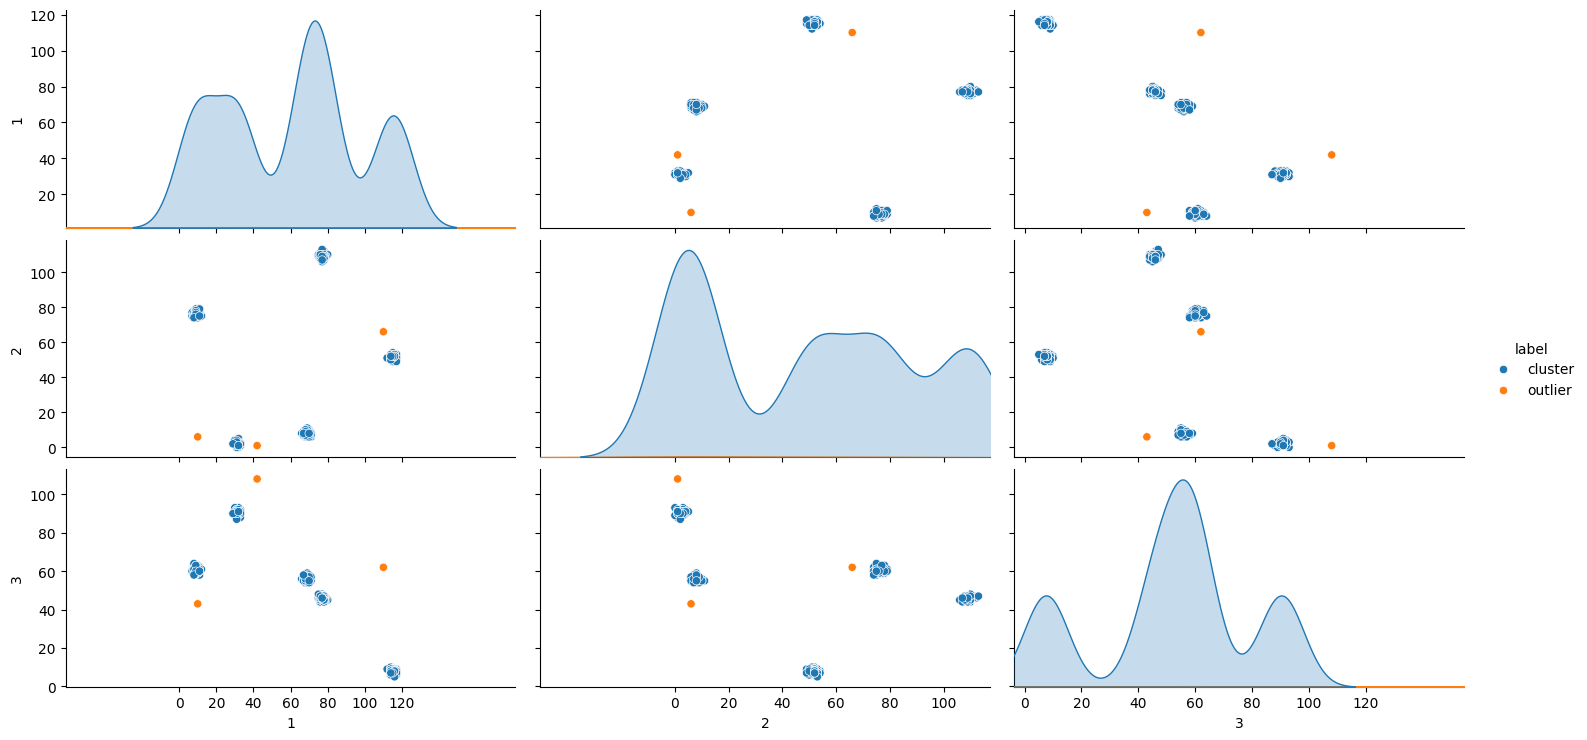

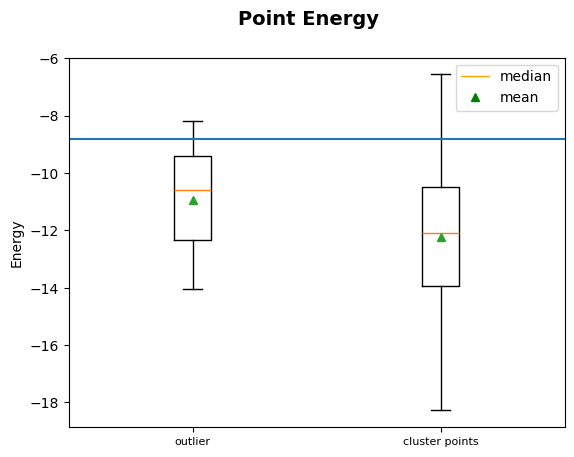

In [7]:
qbm_energies=evaluate_qbm(qbm,testing_dataset,cluster,plot=True)

### Loading Pretrained models
Based on the selected solver we load a pretrained model and evaluate that model on the test dataset.
For example choosing here the solver 'SA' will load a simulated annealer based model with the optimal values for the hyperparamters found through an extensive hyperparameter search.

We also plot the energy distibution of the outliers and the cluster points according to the model.

Loading ./src/models/final_weights_qbm.npz
Outlier threshold:  -36.65339369723997
Calculate outlier Energy


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 110.87it/s]


Calculate cluster energy


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 185.74it/s]


Outlier classification: Results...
Accuracy: 0.9562624254473161, Precision: 0.047619047619047616, Recall: 0.3333333333333333, F1-Score: 0.08333333333333333, 
Num True Negative: 480, Num False Negative: 2, Num True         Positive: 1, Num False Positive: 20
Outlier threshold:  -36.65339369723997
Average clusterpoint energy:  -43.256929891674865
Outlier energy:  [-39.09710223 -37.59274666 -31.10940319]
Currently drawing test dataset


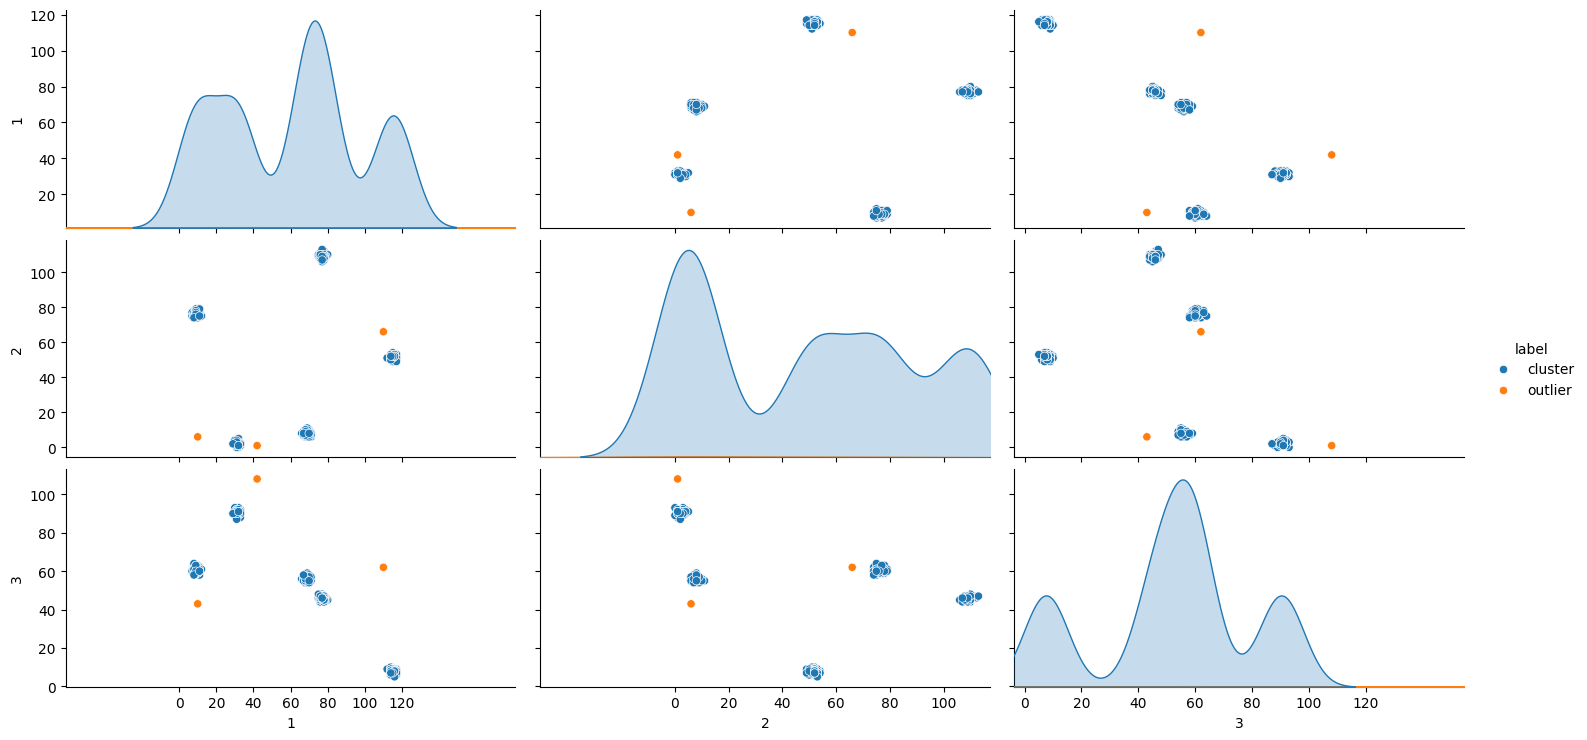

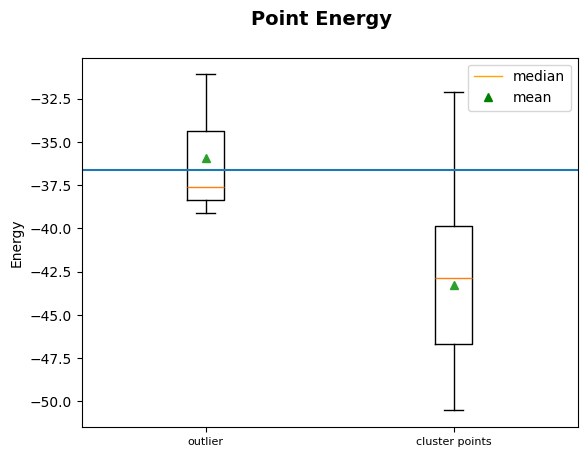

In [9]:
# Select the Solver. Possible inputs ['SA','DWAVE','RBM']
# This notebook shows the use of simulated annealer (SA), the use of DWAVE annealer requires a valid `TOKEN` and access to the D-Wave client.

# Retrieve model Hyperparameters and weights

solver='SA'

params_file_name = './src/models/SA.json'
weights_file_path = (
            "./src/models/final_weights_qbm.npz")


# retrieve model using get_model
qbm=get_model(solver,training_data,params_file_name,weights_file_path )

qbm_energies=evaluate_qbm(qbm,testing_dataset,cluster,plot=True)

## Comparison with classical model

We train a classical RBM model on the same dataset in order to compare it to the QBM.

In [28]:
#train classical model

batch_size=50
learning_rate=0.02
rbm = RBM(training_data,n_hidden_nodes=50, k=2, seed=21, epochs=10,momentum_coefficient=0.5, trained=False, quantile=0.95)

rbm.train_model(batch_size,learning_rate=learning_rate)

rbm_energies=evaluate_rbm(rbm,testing_dataset,cluster=cluster)

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Outlier classification...
Accuracy: 0.9502982107355865, Precision: 0.07692307692307693, Recall: 0.6666666666666666, F1-Score: 0.13793103448275862, Num True Negative: 476, Num False Negative: 1, Num True           Positive: 2, Num False Positive: 24


The energies that are assigned to each point in the testing dataset can now be compared for different models. 
The following plot compares the energy distribution and shows the threshold assigned by each model.

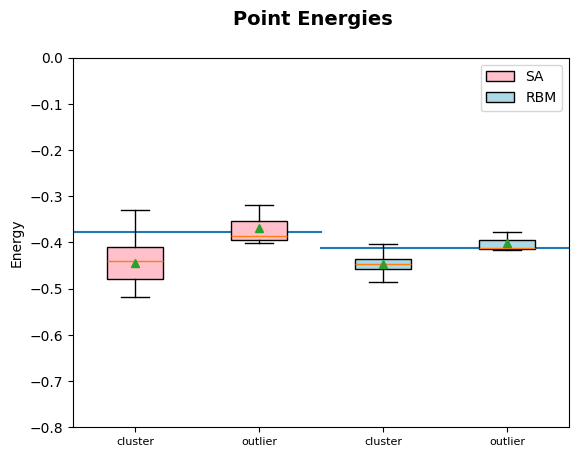

In [29]:

cluster_outlier_energy_data=[qbm_energies,rbm_energies]

thresholds_list=[qbm.outlier_threshold,rbm.outlier_threshold]


## Helper function plotting the output of two models (SA) with (RBM).
compare_models(cluster_outlier_energy_data,thresholds_list)

## Sources

[1] [Amin, M. , Andiyash, E. , Rolfe,J. , Kulchytskyy, B. & Melko, R. (2018). Quantum Boltzmann Machine. Phys. Rev. X,  8.](https://link.aps.org/doi/10.1103/PhysRevX.8.021050)

[2] [Stein, J. , Schuman, D. , et al. (2024). Exploring Unsupervised Anomaly Detection with Quantum Boltzmann Machines in Fraud Detection. Proceedings of the 16th International Conference on Agents and Artificial Intelligence, SCITEPRESS](https://dx.doi.org/10.5220/0012326100003636) 

[3] [Karami, A. (2018). An anomaly-based intrusion detection system in presence of benign outliers with visualization capabilities. Expert Systems with Applications,108, 36-60.](https://doi.org/10.1103/PhysRevA.69.032315)

